In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Our main dataset which excludes supplemental data of patients
final_df2=pd.read_excel('DATA2.xlsx')
final_df2.head()
final_df2.shape

(1287, 39)

In [3]:
#Creating a copy of our data to determine how sparse the data is !
temp=final_df2.copy()
temp.replace(0,np.nan,inplace=True)
import seaborn as sns


<AxesSubplot:>

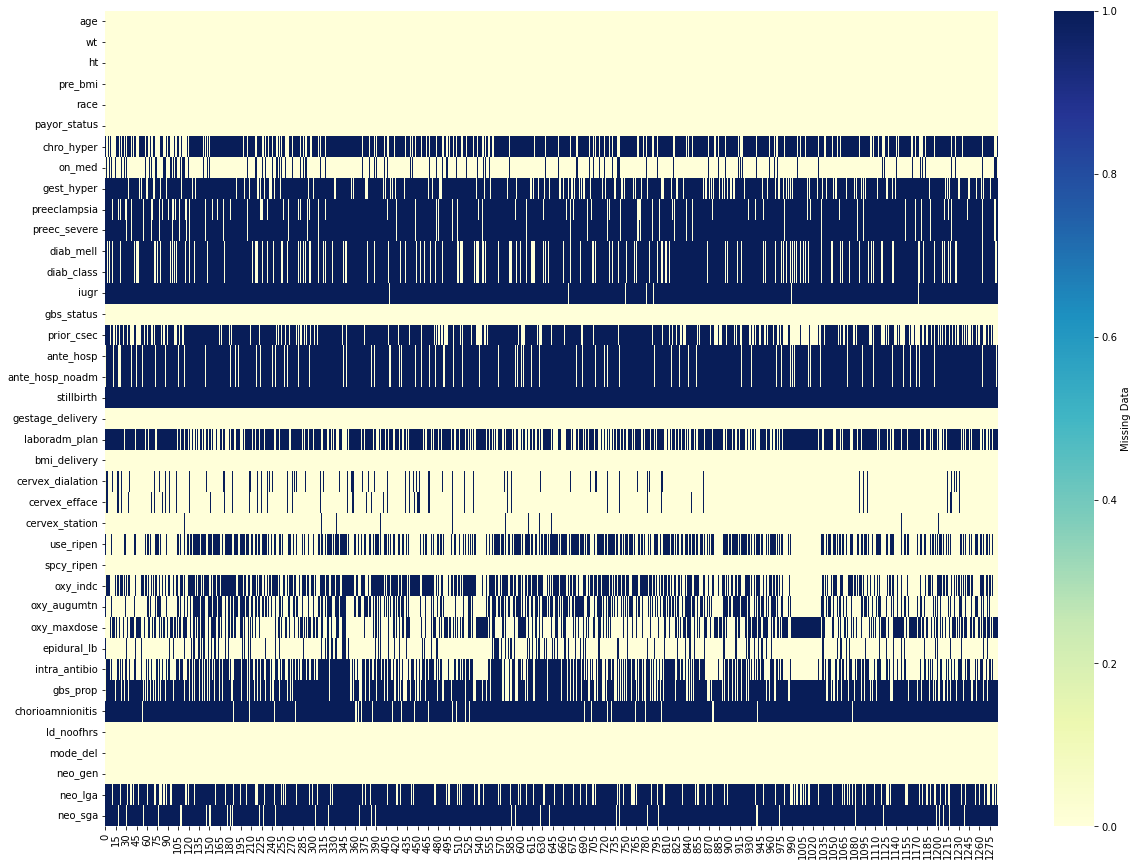

In [4]:
plt.figure(figsize=(20,15))
sns.heatmap(temp.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})


In [5]:
def func(x):
    if x==1 or x==2 or x==3  :
     return 0
    else :
     return 1   
final_df2['mode_del']= final_df2['mode_del'].apply(func) # converting the target variable into binary- cesarean and non-cesarean

In [6]:
#dropping features which are not known prior to cesarean delivery
del final_df2['neo_lga']
del final_df2['neo_sga']
del final_df2['ld_noofhrs']
del final_df2['oxy_maxdose']

# Feature scaling

In [7]:
from numpy import mean
from numpy import std
import sklearn
from sklearn.svm import SVR
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn import svm

In [8]:
categorical_cols = ['race', 'payor_status', 'on_med', 'diab_class', 'gbs_status', 'use_ripen', 'spcy_ripen', 'oxy_indc', 'oxy_augumtn','epidural_lb','intra_antibio', 'neo_gen'] 


final_df2 = pd.get_dummies(final_df2, columns = categorical_cols) #one-hot encoding

In [9]:
final_df2 = final_df2.drop(columns=['race_6','race_7','on_med_2','diab_class_0' ,'on_med_0','gbs_status_3','use_ripen_2','use_ripen_0','spcy_ripen_5','oxy_indc_2','oxy_indc_0','oxy_augumtn_2','oxy_augumtn_0','epidural_lb_2','epidural_lb_0','intra_antibio_2','intra_antibio_0'])

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaled_features = final_df2.copy()
col_names = ['ante_hosp_noadm','age','wt','ht','pre_bmi','bmi_delivery', 'cervex_efface','cervex_station','cervex_dialation','gestage_delivery']
features = scaled_features[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features

In [11]:
x=scaled_features.drop(['mode_del'],axis=1)
y=scaled_features['mode_del']

# Feature selection

In [12]:
cols = list(x.columns)
model= RandomForestClassifier()
rfe = RFE(estimator=model)             
#Transforming data using RFE 
X_rfe = rfe.fit(x,y)                
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['age', 'wt', 'ht', 'pre_bmi', 'chro_hyper', 'diab_mell', 'prior_csec',
       'gestage_delivery', 'laboradm_plan', 'bmi_delivery', 'cervex_dialation',
       'cervex_efface', 'cervex_station', 'gbs_prop', 'chorioamnionitis',
       'race_1', 'payor_status_3', 'use_ripen_1', 'spcy_ripen_2', 'oxy_indc_1',
       'oxy_augumtn_1', 'epidural_lb_1', 'intra_antibio_1', 'neo_gen_2'],
      dtype='object')


In [13]:
importance = rfe.estimator_.feature_importances_
importance

array([0.05183775, 0.0689854 , 0.04721091, 0.06477779, 0.01179959,
       0.01313281, 0.07657181, 0.0597181 , 0.04498185, 0.06431165,
       0.10863676, 0.1278977 , 0.05984935, 0.01277639, 0.01162929,
       0.01238487, 0.01156389, 0.02068808, 0.01047298, 0.02765169,
       0.02263606, 0.04199742, 0.01537505, 0.01311282])

In [14]:
importance = [0.05183775, 0.0689854 , 0.04721091, 0.06477779, 0.01179959,
       0.01313281, 0.07657181, 0.0597181 , 0.04498185, 0.06431165,
       0.10863676, 0.1278977 , 0.05984935, 0.01277639, 0.01162929,
       0.01238487, 0.01156389, 0.02068808, 0.01047298, 0.02765169,
       0.02263606, 0.04199742, 0.01537505, 0.01311282]

In [12]:
#renaming features selected by rf-rfe

features = ['Age', 'Weight', 'Height', 'Pre-pregnancy BMI', 'Chronic Hypertension', 'Diabetes Mellitus','Prior Cesarean',
       'Gestational Age at Delivery', 'In Labor on Admission', 'BMI at Delivery', 'Cervix Dilation',
       'Cervix Effacement', 'Cervix Station', 'GBS Prophylaxis',
       'Chorioamnionitis', 'White (Race)',  'Commercial (Payor Status)',
       ' Use of Ripening', 'Ripening Method - Foley bulb','Oxytocin Induction', 'Oxytocin Augmentation',
       'Epidural Labor', 'Use of Intrapartum Antibiotics',
        'Neonatal Sex (Male)']

In [16]:
df = pd.DataFrame({"features":features,
                  "weights":importance})

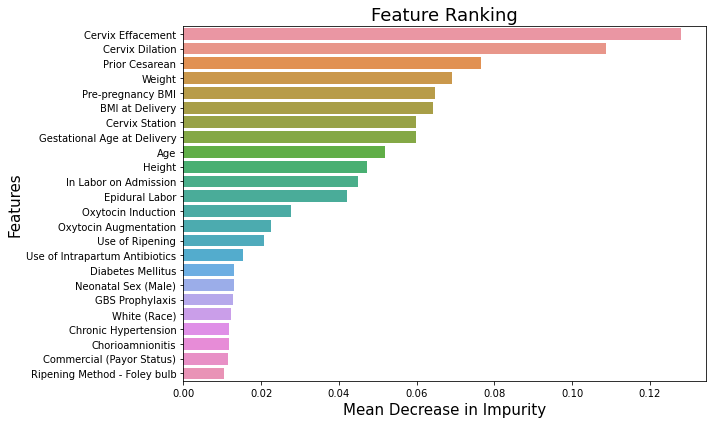

In [17]:
import seaborn as sns 
plt.figure(figsize=(10,6))
#rcParams['figure.figsize'] = 10,6
# make barplot and sort bars
sns.barplot(x='weights',
            y="features", 
            data=df, 
            order=df.sort_values('weights', ascending=False).features)
# set labels
plt.xlabel("Mean Decrease in Impurity", size=15)
plt.ylabel("Features", size=15)
plt.title("Feature Ranking", size=18)
plt.tight_layout()

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
cols = list(x.columns)
model=svm.SVC(kernel='linear',C=10, gamma = 1)
#Initializing RFE model
rfe = RFE(estimator=model)             
#Transforming data using RFE
X_rfe = rfe.fit(x,y)               
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['wt', 'ht', 'pre_bmi', 'diab_mell', 'iugr', 'ante_hosp',
       'ante_hosp_noadm', 'stillbirth', 'laboradm_plan', 'bmi_delivery',
       'cervex_dialation', 'cervex_efface', 'gbs_prop', 'chorioamnionitis',
       'race_2', 'race_5', 'diab_class_1', 'diab_class_3', 'diab_class_4',
       'use_ripen_1', 'spcy_ripen_1', 'spcy_ripen_3', 'oxy_indc_1',
       'oxy_augumtn_1'],
      dtype='object')


In [13]:
#renaming features selected by svm-rfe

features=['Weight', 'Height', 'Pre-pregnancy BMI', 'Diabetes Mellitus','Intrauterine Growth Restriction', 'Antepartum Hospitalization', 'Antepartum Hospital Admissions',
       'Stillbirth', 'In Labor on Admission', 'BMI at Delivery', 'Cervix Dilation',
       'Cervix Effacement', 'GBS Prophylaxis', 'Chorioamnionitis', 'African American (Race)', 'Native American (Race)',
        'Diabetes (Type1)', 'Diabetes (A1)', 'Diabetes (A2)',
        'Use of Ripening', 'Ripening method-Misoprostol', 'Ripening method-Miso and Foley', ' Oxytocin Induction',
        'Oxytocin Augmentation']

In [49]:
importance = rfe.estimator_.coef_
importance


array([[-1.31655239e-02,  5.38535058e-03,  1.09295114e-02,
         4.18587527e-04, -5.13606175e-04,  7.32918075e-04,
        -2.35257139e-03,  2.00038547e+00, -2.00000973e+00,
         1.19415372e-03, -4.62029554e-04, -3.49872224e-04,
        -9.02911995e-05,  1.99961971e+00,  1.35636878e-04,
         2.90775446e-04,  1.99952348e+00, -3.50510098e-04,
        -8.08105337e-04, -1.99985084e+00, -2.37581948e-04,
         1.99912134e+00, -2.00026580e+00, -2.32243705e-04]])

In [14]:
#considering absolute values of weights 

importance = [1.31655239e-02,  5.38535058e-03,  1.09295114e-02,
         4.18587527e-04, 5.13606175e-04,  7.32918075e-04,
        2.35257139e-03,  2.00038547e+00, 2.00000973e+00,
         1.19415372e-03, 4.62029554e-04, 3.49872224e-04,
        9.02911995e-05,  1.99961971e+00,  1.35636878e-04,
         2.90775446e-04,  1.99952348e+00, 3.50510098e-04,
        8.08105337e-04, 1.99985084e+00, 2.37581948e-04,
         1.99912134e+00, 2.00026580e+00, 2.32243705e-04]

In [51]:
df = pd.DataFrame({"features":features,
                  "weights":importance})

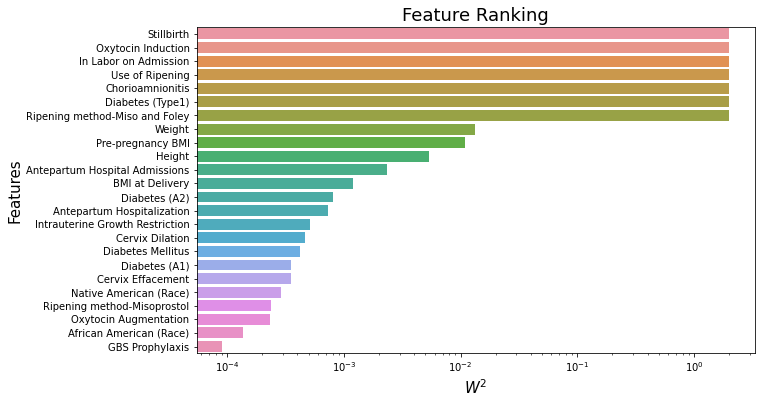

In [52]:
import seaborn as sns 
plt.figure(figsize=(10,6))
#from matplotlib import rcParams

#rcParams['figure.figsize'] = 10,6
# make barplot and sort bars
ax= sns.barplot(x='weights',
            y='features', 
            data=df, 
            order=df.sort_values('weights', ascending=False).features)
# set labels
plt.xlabel("$W^2$", size=15)
plt.ylabel("Features", size=15)
plt.title("Feature Ranking", size=18)
plt.xscale('log')
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


# Model Fitting

In [15]:
# considered svm-rfe selected features

NEW = scaled_features[['wt', 'ht', 'pre_bmi', 'diab_mell', 'iugr', 'ante_hosp',
       'ante_hosp_noadm', 'stillbirth', 'laboradm_plan', 'bmi_delivery',
       'cervex_dialation', 'cervex_efface', 'gbs_prop', 'chorioamnionitis',
       'race_2', 'race_5', 'diab_class_1', 'diab_class_3', 'diab_class_4',
       'use_ripen_1', 'spcy_ripen_1', 'spcy_ripen_3', 'oxy_indc_1',
       'oxy_augumtn_1','mode_del']]

In [16]:
# considering rf-rfe selected features
new = scaled_features[['age', 'wt', 'ht', 'pre_bmi', 'chro_hyper', 'diab_mell', 'prior_csec',
       'gestage_delivery', 'laboradm_plan', 'bmi_delivery', 'cervex_dialation',
       'cervex_efface', 'cervex_station', 'gbs_prop', 'chorioamnionitis',
       'race_1', 'payor_status_3', 'use_ripen_1', 'spcy_ripen_2', 'oxy_indc_1',
       'oxy_augumtn_1', 'epidural_lb_1', 'intra_antibio_1', 'neo_gen_2','mode_del']]

In [25]:
X1=new.drop(['mode_del'],axis=1)
Y1=new['mode_del']
X2=NEW.drop(['Mode of Delivery'],axis=1)
Y2=NEW['Mode of Delivery']

In [21]:
NEW=NEW.rename(columns={'wt':'Weight', 'ht':'Height', 'pre_bmi':'Pre-Pregnancy BMI','diab_mell': 'Diabetes Mellitus', 'iugr': 'Intrauterine Growth Restriction','ante_hosp':'Antepartum Hospitalization',
       'ante_hosp_noadm':'Antepartum Hospital admissions', 'stillbirth':'Stillbirth', 'laboradm_plan':'In Labor on Admission',
       'bmi_delivery':'BMI at Delivery', 'cervex_dialation':'Cervix Dilation', 'cervex_efface':'Cervix Effacement','gbs_prop':'GBS Prophylaxis','chorioamnionitis':'Chorioamnionitis',
        'race_2':'African American', 'race_5':'Native American', 'diab_class_1':'Diabetes (Type 1)',
       'diab_class_3':'Diabetes (A1)', 'diab_class_4':'Diabetes (A2)', 'use_ripen_1':'Use of Ripening','spcy_ripen_1':'Ripening Method-Misoprostol','spcy_ripen_3':'Ripening Method-Miso and Foley',
       'oxy_indc_1':'Oxytocin Induction', 'oxy_augumtn_1':'Oxytocin Augmentation', 'mode_del':'Mode of Delivery'})

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

tuned_parameters = {'alpha': [10 ** a for a in range(-6, 2)]}

LR=[]
DT=[]
RF=[]
SVMLI=[]
SVMRB=[]
GB=[]
LASSO=[]
a1=[]
a2=[]
a3=[]
a4=[]
a5=[]
a6=[]
a7=[]

for seed in range(100,200):
 x_train1, x_test1, y_train1, y_test1 = train_test_split(X2 , Y2, stratify = Y2,test_size=0.3, random_state=seed)
 x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, stratify=y,test_size=0.3, random_state=seed)
 logreg = LogisticRegression() 
 logreg.fit(x_train1, y_train1)
 model = dtc(criterion='entropy', max_depth=3, min_samples_leaf=5)
 model.fit(x_train1, y_train1) 
 clf=RandomForestClassifier()
 clf.fit(x_train1,y_train1)
 lk = svm.SVC(kernel='linear', C= 10, gamma = 1, probability=True) # Linear Kernel
 lk.fit(x_train1, y_train1)
 rk = svm.SVC(kernel='rbf', C = 1000 , gamma= 0.01 , probability=True) # radial Kernel
 rk.fit(x_train1, y_train1)
 model_gbm = GradientBoostingClassifier(learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1)
 model_gbm.fit(x_train2, y_train2)
 las = GridSearchCV(SGDClassifier(loss='log', penalty='l1', shuffle=True, verbose=False, n_jobs=10, average=False, class_weight='balanced')
                  , tuned_parameters, cv=10, scoring='f1_macro')
 las.fit(x_train2, y_train2)
 gbm_pred= model_gbm.predict(x_test2)   
 y_pred = logreg.predict(x_test1)
 pred_model = model.predict(x_test1)
 y_pre=clf.predict(x_test1)
 pred = lk.predict(x_test1)
 y_pr = rk.predict(x_test1)
 las_pred = las.predict(x_test2)  
 #print("LR", roc_auc_score(y_test,y_pred),"DT",roc_auc_score(y_test, pred_model),"RF",roc_auc_score(y_test, y_pre),"SVMLI",roc_auc_score(y_test,pred),"SVMRB",roc_auc_score(y_test,y_pr))
 LR.append(roc_auc_score(y_test1,y_pred)) # AUC SCORES
 DT.append(roc_auc_score(y_test1, pred_model))   
 RF.append(roc_auc_score(y_test1, y_pre))
 SVMLI.append(roc_auc_score(y_test1,pred))
 SVMRB.append(roc_auc_score(y_test1,y_pr))
 GB.append(roc_auc_score(y_test2,gbm_pred)) 
 LASSO.append(roc_auc_score(y_test2,las_pred))  
 #ACC SCORES
 a1.append(logreg.score(x_test1, y_test1))
 a2.append(model.score(x_test1,y_test1))
 a3.append(clf.score(x_test1, y_test1))
 a4.append(lk.score(x_test1, y_test1))
 a5.append(rk.score(x_test1, y_test1))   
 a6.append(model_gbm.score(x_test2, y_test2))   
 a7.append(las.score(x_test2, y_test2))   

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3368           0.0209            0.79s
         2           1.3095           0.0246            0.39s
         3           1.2824           0.0354            0.26s
         4           1.2555           0.0277            0.19s
         5           1.2135           0.0220            0.15s
         6           1.1931           0.0250            0.13s
         7           1.1856           0.0240            0.11s
         8           1.1617           0.0193            0.18s
         9           1.1324           0.0020            0.16s
        10           1.1316           0.0097            0.14s
        20           0.9865           0.0124            0.10s
        30           0.9128           0.0050            0.07s
        40           0.8281           0.0027            0.06s
        50           0.8143           0.0030            0.05s
        60           0.7487          -0.0004            0.04s
       

In [27]:
print(*LR, sep = "\n")

0.8195944845556703
0.8212909179740514
0.8022094348840997
0.8101216003474296
0.8238830682373378
0.84392812550893
0.8147087563107323
0.8078280223657782
0.8218880625373216
0.8462217034905815
0.8304652299006569
0.8232180663373324
0.7824629498941426
0.8071630204657727
0.81108517452907
0.8248466424189783
0.8101216003474296
0.8048694424841214
0.8577574507355735
0.8229873513924326
0.8406709733456381
0.830763802182292
0.7795043700124857
0.8104201726290647
0.8350523858639596
0.8416345475272786
0.8113837468107052
0.8488138537538679
0.8225530644373269
0.8031730090657402
0.8369795342272406
0.8117501764290755
0.8150073285923674
0.8245480701373433
0.80257586450247
0.8176673361923892
0.8363823896639705
0.7999837142391836
0.7900086857391021
0.808859453884154
0.820625916074046
0.795993702839151
0.7782422235492102
0.8275745073557353
0.7931029802942293
0.7868193909125454
0.7934015525758645
0.7996172846208132
0.7874165354758157
0.8264752185006243
0.8179659084740242
0.8189973399924
0.8002144291840834
0.8275

In [28]:
Data = {'LR': LR, 
        'DT': DT,
        'RF': RF,
        'SVM LI': SVMLI,
        'SVM RB': SVMRB,
        'GB': GB,
        'LASSO':LASSO
       }
AUC_1=pd.DataFrame(Data)
data = {'LR': a1, 
        'DT': a2,
        'RF': a3,
        'SVM LI': a4,
        'SVM RB': a5,
        'GB':a6,
        'LASSO':a7
       }
ACC_1=pd.DataFrame(data)

In [29]:
# calculating AUC and ACC of all fitted ml models

AUC_1.describe()
ACC_1.describe()

,LR,DT,RF,SVM LI,SVM RB,GB,LASSO
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.831447,0.768398,0.807468,0.816796,0.824470,0.811731,0.803434
std,0.017386,0.019926,0.018603,0.017240,0.017722,0.016982,0.021107
min,0.780362,0.687339,0.754522,0.770026,0.772610,0.759690,0.762247
25%,0.821059,0.759044,0.795866,0.806202,0.811370,0.801034,0.789299
50%,0.832041,0.770026,0.808786,0.819121,0.824289,0.811370,0.805294
75%,0.842377,0.782946,0.819121,0.826873,0.835271,0.821705,0.817263
max,0.881137,0.811370,0.850129,0.860465,0.875969,0.852713,0.867509


In [30]:
from sklearn import metrics
recall_sensitivity = metrics.recall_score(y_test1, pred, pos_label=1)
recall_specificity = metrics.recall_score(y_test1, pred, pos_label=0)
recall_sensitivity, recall_specificity 

(0.7159763313609467, 0.963302752293578)

<AxesSubplot:>

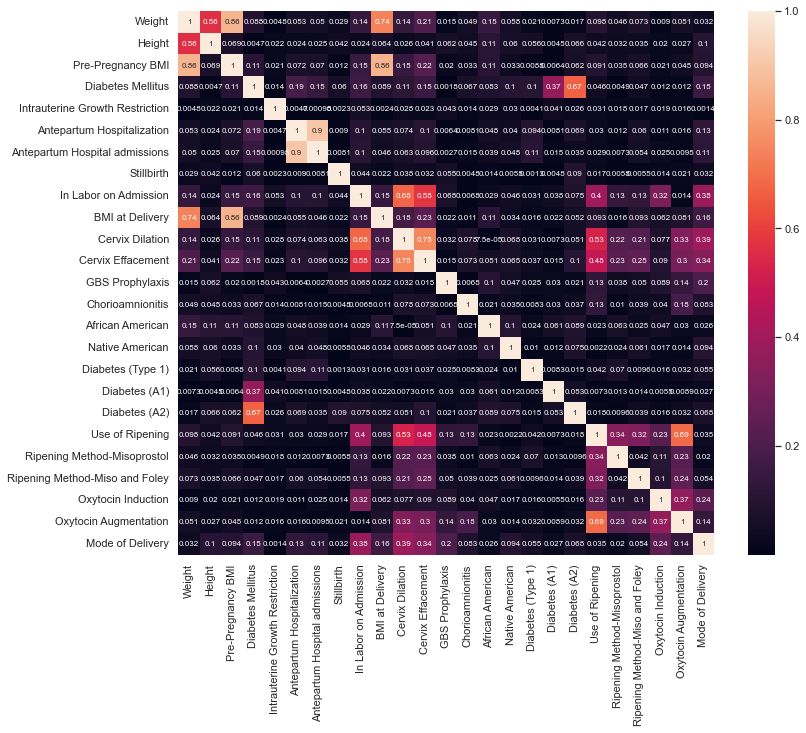

In [31]:
# logistic regression from svm-rfe outperformed others. Model is further simplified by observation correlation between features.

import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(NEW.corr().abs(),annot=True,annot_kws={'size':8})

In [32]:
# new dataframe is created by dropping correlated features when threshold is set to 0.7
corr = scaled_features[[ 'ht', 'pre_bmi', 'diab_mell', 'iugr', 'ante_hosp',
        'stillbirth', 'laboradm_plan', 'bmi_delivery',
       'cervex_dialation', 'gbs_prop', 'chorioamnionitis',
       'race_2', 'race_5', 'diab_class_1', 'diab_class_3', 'diab_class_4',
       'use_ripen_1', 'spcy_ripen_1', 'spcy_ripen_3', 'oxy_indc_1',
       'oxy_augumtn_1','mode_del']]

In [33]:
corr = corr.rename(columns = {'ht':'Height', 'pre_bmi':'Pre-Pregnancy BMI', 'diab_mell':'Diabetes Mellitus', 'iugr':'Intrauterine Growth Restriction', 'ante_hosp':'Antepartum Hospitalization',
        'stillbirth':'Stillbirth', 'laboradm_plan':'In Labor on Admission', 'bmi_delivery':'BMI at Delivery',
       'cervex_dialation': 'Cervix Dilation', 'gbs_prop':'GBS Prophylaxis', 'chorioamnionitis': 'Chorioamnionitis',
       'race_2':'African American', 'race_5':'Native American', 'diab_class_1':'Diabetes (Type 1)', 'diab_class_3':'Diabetes (A1)', 'diab_class_4':'Diabetes (A2)',
       'use_ripen_1':'Use of Ripening', 'spcy_ripen_1':'Ripening Method-Misoprostol', 'spcy_ripen_3':'Ripening Method-Miso and Foley', 'oxy_indc_1':'Oxytocin Induction',
       'oxy_augumtn_1':'Oxytocin Augmentation','mode_del':'Mode of Delivery'})

In [34]:
X=corr.drop(['Mode of Delivery'],axis=1)
Y=corr['Mode of Delivery']

# Hyperparameter tuning

In [39]:

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [49]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
dt =  DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(x, y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [50]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)

In [51]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x, y)
grid_result.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [33]:
# same ml models were fit on corr dataframe obtained after feature drop

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
LR2=[]
DT2=[]
RF2=[]
SVMLI2=[]
SVMRB2=[]
GB2=[]
ac1=[]
ac2=[]
ac3=[]
ac4=[]
ac5=[]
ac6=[]

for seed in range(100,200):
 x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y,test_size=0.3, random_state=seed)
 logreg = LogisticRegression() 
 logreg.fit(x_train, y_train)
 model = dtc(criterion = 'entropy', max_depth = 5)
 model.fit(x_train, y_train) 
 clf=RandomForestClassifier(n_estimators=100)
 clf.fit(x_train,y_train)
 lk = svm.SVC(kernel='linear', C= 10, gamma = 1, probability=True) # Linear Kernel
 lk.fit(x_train, y_train)
 rk = svm.SVC(kernel='rbf', C = 1000 , gamma= 0.01 , probability=True) # radial Kernel
 rk.fit(x_train, y_train)
 y_pred = logreg.predict(x_test)
 pred_model = model.predict(x_test)
 y_pre=clf.predict(x_test)
 pred = lk.predict(x_test)
 y_pr = rk.predict(x_test)
 LR2.append(roc_auc_score(y_test,y_pred))
 DT2.append(roc_auc_score(y_test, pred_model))   
 RF2.append(roc_auc_score(y_test, y_pre))
 SVMLI2.append(roc_auc_score(y_test,pred))
 SVMRB2.append(roc_auc_score(y_test,y_pr))  
 ac1.append(logreg.score(x_test,y_test))
 ac2.append(model.score(x_test,y_test))
 ac3.append(clf.score(x_test,y_test))
 ac4.append(lk.score(x_test,y_test))
 ac5.append(rk.score(x_test,y_test)) 
   
 

In [30]:
from sklearn import metrics
recall_sensitivity = metrics.recall_score(y_test,y_pred, pos_label=1)
recall_specificity = metrics.recall_score(y_test,y_pred, pos_label=0)
recall_sensitivity, recall_specificity 

(0.7692307692307693, 0.9495412844036697)

In [39]:
Data2 = {'LR': LR2, 
        'DT': DT2,
        'RF': RF2,
        'SVM LI': SVMLI2,
        'SVM RB': SVMRB2,
         
       }
data2 = {'LR': ac1, 
        'DT': ac2,
        'RF': ac3,
        'SVM LI': ac4,
        'SVM RB': ac5,
         
       }
ACC_SVM=pd.DataFrame(data2)
AUC_SVM =pd.DataFrame(Data2)

In [26]:
AUC_SVM.describe()

,LR,DT,RF,SVM LI,SVM RB
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.819565,0.782102,0.812544,0.808657,0.808185
std,0.017069,0.018829,0.018151,0.022307,0.019617
min,0.759826,0.731638,0.768036,0.747991,0.728978
25%,0.809938,0.771066,0.799675,0.792485,0.796974
50%,0.820775,0.785272,0.815706,0.812564,0.807529
75%,0.831079,0.795207,0.824616,0.823310,0.821440
max,0.859386,0.819961,0.859020,0.856794,0.851840


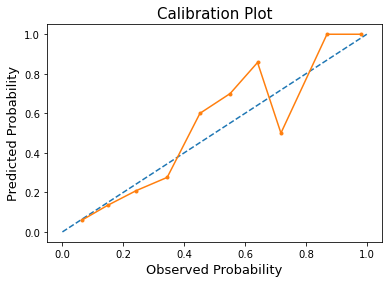

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(logreg,method='sigmoid',cv=10)
calibrated.fit(x_train1, y_train1)
# predict probabilities
probs = calibrated.predict_proba(x_test1)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test1, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.xlabel('Observed Probability', fontsize =13)
pyplot.ylabel('Predicted Probability', fontsize = 13)
pyplot.title('Calibration Plot', fontsize = 15)
pyplot.show()

In [19]:
pred_prob1 = logreg.predict_proba(x_test1)
pred_prob2 = model.predict_proba(x_test1)
pred_prob3 = clf.predict_proba(x_test1)
pred_prob4 = lk.predict_proba(x_test1)
pred_prob5 = rk.predict_proba(x_test1)

In [20]:
from sklearn.metrics import roc_curve
#cv = StratifiedKFold(n_splits=10)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test1, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test1, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test1, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test1, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test1, pred_prob5[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test1))]
p_fpr, p_tpr, _ = roc_curve(y_test1, random_probs, pos_label=1)

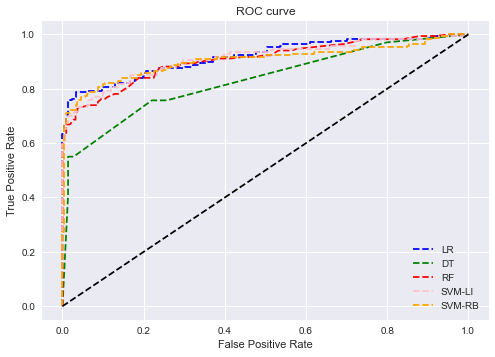

In [23]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='blue', label='LR')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='DT')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='RF')
plt.plot(fpr4, tpr4, linestyle='--',color='pink', label='SVM-LI')
plt.plot(fpr5, tpr5, linestyle='--',color='orange', label='SVM-RB')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=500)
plt.show();

In [16]:
import statsmodels.api as sm
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary())

         Current function value: 0.433122
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       Mode of Delivery   No. Observations:                 1287
Model:                          Logit   Df Residuals:                     1266
Method:                           MLE   Df Model:                           20
Date:                Fri, 20 May 2022   Pseudo R-squ.:                  0.3676
Time:                        15:06:49   Log-Likelihood:                -557.43
converged:                      False   LL-Null:                       -881.47
Covariance Type:            nonrobust   LLR p-value:                2.072e-124
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Height                              2.1840      0.473      4.616      0.000       1.257       3.111
Pr

C:\Users\Rajasri\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Data Visualization

In [43]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train1),
    feature_names=x_train1.columns,
    class_names=['non-cesarean', 'cesarean'],
    mode='classification', verbose=True
)

In [27]:
x_train1.columns

Index(['ht', 'pre_bmi', 'diab_mell', 'iugr', 'ante_hosp', 'stillbirth',
       'laboradm_plan', 'bmi_delivery', 'cervex_dialation', 'gbs_prop',
       'chorioamnionitis', 'race_2', 'race_5', 'diab_class_1', 'diab_class_3',
       'diab_class_4', 'use_ripen_1', 'spcy_ripen_1', 'spcy_ripen_3',
       'oxy_indc_1', 'oxy_augumtn_1'],
      dtype='object')

In [39]:
x_test1.iloc[2]

Height                             0.500000
Pre-Pregnancy BMI                  0.212538
Diabetes Mellitus                  0.000000
Intrauterine Growth Restriction    0.000000
Antepartum Hospitalization         0.000000
Stillbirth                         0.000000
In Labor on Admission              0.000000
BMI at Delivery                    0.017787
Cervix Dilation                    0.300000
GBS Prophylaxis                    0.000000
Chorioamnionitis                   0.000000
African American                   0.000000
Native American                    0.000000
Diabetes (Type 1)                  0.000000
Diabetes (A1)                      0.000000
Diabetes (A2)                      0.000000
Use of Ripening                    0.000000
Ripening Method-Misoprostol        0.000000
Ripening Method-Miso and Foley     0.000000
Oxytocin Induction                 1.000000
Oxytocin Augmentation              0.000000
Name: 568, dtype: float64

In [24]:
x_train1.shape

(900, 28)

C:\Users\Rajasri\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Intercept 0.43480391634370286
Prediction_local [0.33225476]
Right: 0.1933298829306847


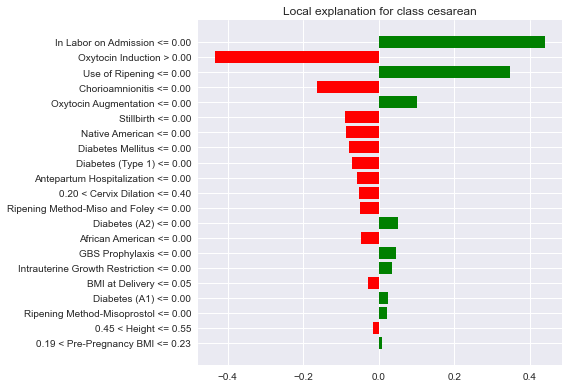

In [44]:
exp = explainer.explain_instance(
    data_row=x_test1.iloc[2], 
    predict_fn=logreg.predict_proba,
    num_features=28
)

plt = exp.as_pyplot_figure()
#plt.constrained_layout()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

In [27]:
#DLIME
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(np.array(x_train),mode="classification", feature_names=x_train.columns,
                                 class_names=['0','1'], discretize_continuous=True,  verbose=False)

In [28]:
#Apply hierarchial clustering on training data
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(new)
names = list(x_train.columns)+["membership"]
clustered_data = np.column_stack([new, clustering.labels_])

In [29]:
# Train KNN to find Local subspace
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(x_train)
distances, indices = nbrs.kneighbors(x_test)
clabel = clustering.labels_

In [30]:
# Computes the similarity of  items 
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

#Computes thedissimilarity of items 
def jaccard_distance(usecase):
    sim = []
    for l in usecase:
        i_sim = []
        for j in usecase:
            i_sim.append(1 - jaccard_similarity(l, j))
        sim.append(i_sim)
    return sim

In [31]:

    def explain_instance_hclust(self,
                         data_row,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=5000,
                         distance_metric='euclidean',
                         model_regressor=None,
                         clustered_data = None,
                         regressor='linear', explainer = 'lime'):

        if explainer == 'lime':
            data, inverse = self.__data_inverse(data_row, num_samples)
            scaled_data = (data - self.scaler.mean_) / self.scaler.scale_

            distances = sklearn.metrics.pairwise_distances(
                scaled_data,
                scaled_data[0].reshape(1, -1),
                metric=distance_metric
            ).ravel()

            yss = predict_fn(inverse)
        else:
            data, inverse = self.__data_inverse_hclust(data_row, clustered_data)
            scaled_data = (data - self.scaler.mean_) / self.scaler.scale_

            distances = sklearn.metrics.pairwise_distances(
                    scaled_data,
                    scaled_data[0].reshape(1, -1),
                    metric=distance_metric
            ).ravel()

            yss = predict_fn(clustered_data)

        if self.mode == "classification":
            if len(yss.shape) == 1:
                raise NotImplementedError("LIME does not currently support "
                                          "classifier models without probability "
                                          "scores. If this conflicts with your "
                                          "use case, please let us know: "
                                          "https://github.com/datascienceinc/lime/issues/16")
            elif len(yss.shape) == 2:
                if self.class_names is None:
                    self.class_names = [str(x) for x in range(yss[0].shape[0])]
                else:
                    self.class_names = list(self.class_names)
                if not np.allclose(yss.sum(axis=1), 1.0):
                    warnings.warn("""
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    """)
            else:
                raise ValueError("Your model outputs "
                                 "arrays with {} dimensions".format(len(yss.shape)))

        else:
            try:
                assert isinstance(yss, np.ndarray) and len(yss.shape) == 1
            except AssertionError:
                raise ValueError("Your model needs to output single-dimensional \
                    numpyarrays, not arrays of {} dimensions".format(yss.shape))

            predicted_value = yss[0]
            min_y = min(yss)
            max_y = max(yss)

            yss = yss[:, np.newaxis]

        feature_names = copy.deepcopy(self.feature_names)
        if feature_names is None:
            feature_names = [str(x) for x in range(data_row.shape[0])]

        values = self.convert_and_round(data_row)

        for i in self.categorical_features:
            if self.discretizer is not None and i in self.discretizer.lambdas:
                continue
            name = int(data_row[i])
            if i in self.categorical_names:
                name = self.categorical_names[i][name]
            feature_names[i] = '%s=%s' % (feature_names[i], name)
            values[i] = 'True'
        categorical_features = self.categorical_features

        discretized_feature_names = None
        if self.discretizer is not None:
            categorical_features = range(data.shape[1])
            discretized_instance = self.discretizer.discretize(data_row)
            discretized_feature_names = copy.deepcopy(feature_names)
            for f in self.discretizer.names:
                discretized_feature_names[f] = self.discretizer.names[f][int(
                        discretized_instance[f])]

        domain_mapper = TableDomainMapper(feature_names,
                                          values,
                                          scaled_data[0],
                                          categorical_features=categorical_features,
                                          discretized_feature_names=discretized_feature_names)
        ret_exp = explanation.Explanation(domain_mapper,
                                          mode=self.mode,
                                          class_names=self.class_names)
        ret_exp.scaled_data = scaled_data
        if self.mode == "classification":
            ret_exp.predict_proba = yss[0]
            if top_labels:
                labels = np.argsort(yss[0])[-top_labels:]
                ret_exp.top_labels = list(labels)
                ret_exp.top_labels.reverse()
        else:
            ret_exp.predicted_value = predicted_value
            ret_exp.min_value = min_y
            ret_exp.max_value = max_y
            labels = [0]

        for label in labels:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score[label], ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                    scaled_data,
                    yss,
                    distances,
                    label,
                    num_features,
                    model_regressor=model_regressor,
                    feature_selection=self.feature_selection, regressor=regressor)

        if self.mode == "regression":
            ret_exp.intercept[1] = ret_exp.intercept[0]
            ret_exp.local_exp[1] = [x for x in ret_exp.local_exp[0]]
            ret_exp.local_exp[0] = [(i, -1 * j) for i, j in ret_exp.local_exp[1]]

        return ret_exp

In [32]:
def __data_inverse_hclust(self,
                       data_row,
                       samples):
        data = np.zeros((samples.shape[0], data_row.shape[0]))
        categorical_features = range(data_row.shape[0])

        first_row = self.discretizer.discretize(data_row)
        data[0] = data_row.copy()
        inverse = data.copy()
        for column in categorical_features:
            values = self.feature_values[column]
            freqs = self.feature_frequencies[column]

            inverse_column = samples[:,column]
                # self.random_state.choice(values, size=num_samples,
                #                                       replace=True, p=freqs)
            binary_column = np.array([1 if x == data_row[column]
                                      else 0 for x in inverse_column])
            binary_column[0] = 1
            inverse_column[0] = data[0, column]
            data[:, column] = binary_column
            inverse[:, column] = inverse_column
        # if self.discretizer is not None:
        #     inverse[1:] = self.discretizer.undiscretize(inverse[1:])
        inverse[0] = data_row
        return data, inverse

In [33]:
#explain an Instance With LIME and DLIME
x = 2

dlime_exp = []
lime_exp = []

for i in range(0, 10):
        p_label = clabel[indices[x]]
        N = clustered_data[clustered_data[:, 30] == p_label]
        subset = np.delete(N, 30, axis=1)

        exp_dlime = explain_instance_hclust(x_test.iloc[x],
                                             logreg.predict_proba,
                                             num_features=10,
                                             clustered_data = subset,
                                             regressor = 'linear', explainer='dlime', labels=(0,1))

        fig_dlime, r_features = exp_dlime.as_pyplot_to_figure(type='h', name = i+.2, label='0')
        fig_dlime.show()
        dlime_exp.append(r_features)


        exp_lime = explain_instance_hclust(x_test.iloc[x],
                                             logreg.predict_proba,
                                             num_features=10,
                                             regressor = 'linear', explainer = 'lime', labels=(0,1))

        fig_lime, r_features = exp_lime.as_pyplot_to_figure(type='h', name = i+.3, label='0')
        #fig_lime.show()
        lime_exp.append(r_features)

AttributeError: 'Series' object has no attribute '__data_inverse_hclust'

In [17]:
import shap

In [21]:
shap.initjs()
log_reg_explainer1 = shap.LinearExplainer(logreg, x_train1)

In [24]:
sample_idx = 0

shap_vals = log_reg_explainer1.shap_values(x_test1.iloc[sample_idx])

In [25]:
shap.force_plot(log_reg_explainer1.expected_value,
                log_reg_explainer1.shap_values(x_test1.iloc[0]),
                feature_names=x_train1.columns,
                out_names="Mode of Delivery")

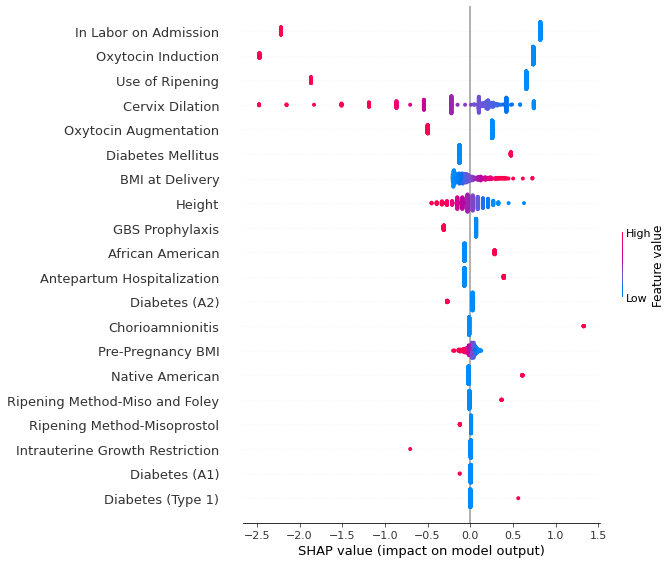

In [38]:
shap.summary_plot(log_reg_explainer1.shap_values(x_test1),
                  features = x_test1,
                  feature_names=x_train1.columns)